In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data = pd.read_csv("./Breast_cancer_data.csv")

data.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0


In [3]:
data.shape

(569, 6)

5 feature and  1 diagnosis,
by understanding these features we need to find wheater someone have breast cancer or not


every feature is a continous variable

naive bayes dont use continuos value so we need to change into categorical value

<AxesSubplot:>

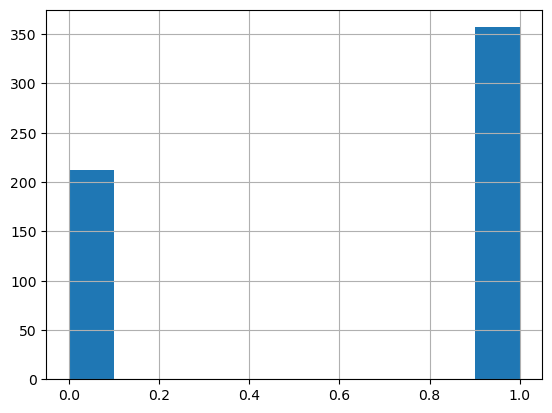

In [4]:
data['diagnosis'].hist()

lets check if the features are independend ornot

In [5]:
data.corr()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
mean_radius,1.000000,0.323782,0.997855,0.987357,0.170581,-0.730029
mean_texture,0.323782,1.000000,0.329533,0.321086,-0.023389,-0.415185
mean_perimeter,0.997855,0.329533,1.000000,0.986507,0.207278,-0.742636
mean_area,0.987357,0.321086,0.986507,1.000000,0.177028,-0.708984
mean_smoothness,0.170581,-0.023389,0.207278,0.177028,1.000000,-0.358560
diagnosis,-0.730029,-0.415185,-0.742636,-0.708984,-0.358560,1.000000


<AxesSubplot:>

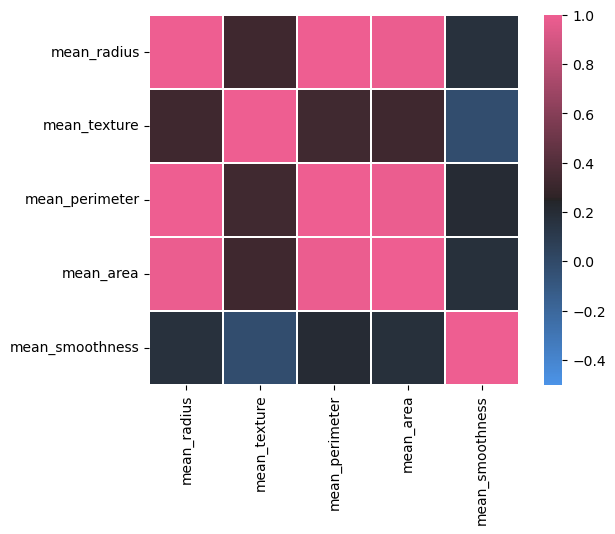

In [6]:
corr = data.iloc[:,:-1].corr(method="pearson")
cmap = sns.diverging_palette(250, 354, 80, 60, center='dark', as_cmap=True)
sns.heatmap(corr, vmin=-.5, cmap=cmap, square=True, linewidths=.2)

In [7]:
corr_min = corr.min().min()
corr_min

-0.023388515998423325

<AxesSubplot:>

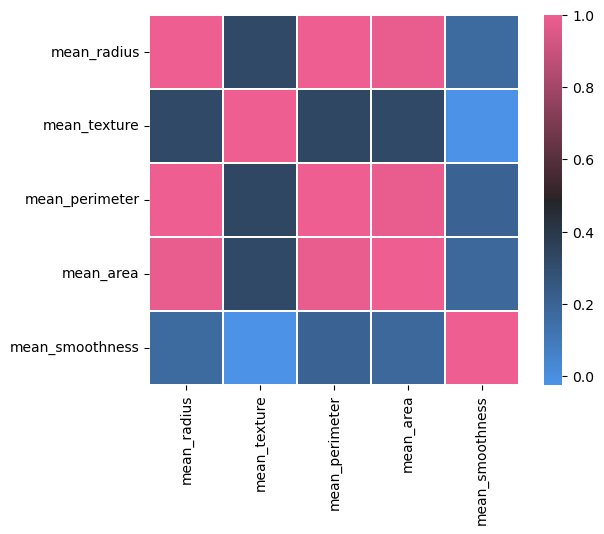

In [8]:
corr = data.iloc[:,:-1].corr(method="pearson")
cmap = sns.diverging_palette(250, 354, 80, 60, center='dark', as_cmap=True)
sns.heatmap(corr, vmin=corr_min, cmap=cmap, square=True, linewidths=.2)

there are somany positive correlation there

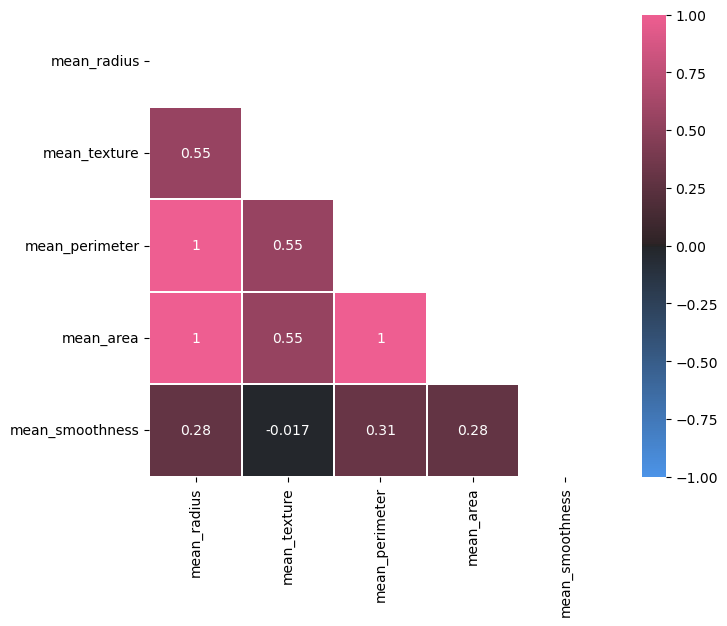

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sample correlation matrix (replace this with your own)
corr = {
    'mean_radius': [1.000000, 0.323782, 0.997855, 0.987357, 0.170581, -0.730029],
    'mean_texture': [0.323782, 1.000000, 0.329533, 0.321086, -0.023389, -0.415185],
    'mean_perimeter': [0.997855, 0.329533, 1.000000, 0.986507, 0.207278, -0.742636],
    'mean_area': [0.987357, 0.321086, 0.986507, 1.000000, 0.177028, -0.708984],
    'mean_smoothness': [0.170581, -0.023389, 0.207278, 0.177028, 1.000000, -0.358560]
}

df = pd.DataFrame(corr)

# Create a mask for the lower triangle
mask = np.triu(np.ones_like(df.corr(), dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Define a colormap
cmap = sns.diverging_palette(250, 354, 80, 60, center='dark', as_cmap=True)

# Draw the heatmap with the mask
sns.heatmap(df.corr(), mask=mask, cmap=cmap, vmin=-1, vmax=1, annot=True, square=True, linewidths=.2)

plt.show()


we can see a very good correlation between area and peremeter and area and radius

so i am going to take mean_radius onlly, ingnoreth eother 2

In [10]:
data.columns

Index(['mean_radius', 'mean_texture', 'mean_perimeter', 'mean_area',
       'mean_smoothness', 'diagnosis'],
      dtype='object')

In [22]:
data = data[['mean_radius', 'mean_texture',
       'mean_smoothness', 'diagnosis']]

In [12]:
df.sample()

,mean_radius,mean_texture,mean_smoothness,diagnosis
98,11.6,12.84,0.08983,1


<AxesSubplot:xlabel='mean_texture', ylabel='Count'>

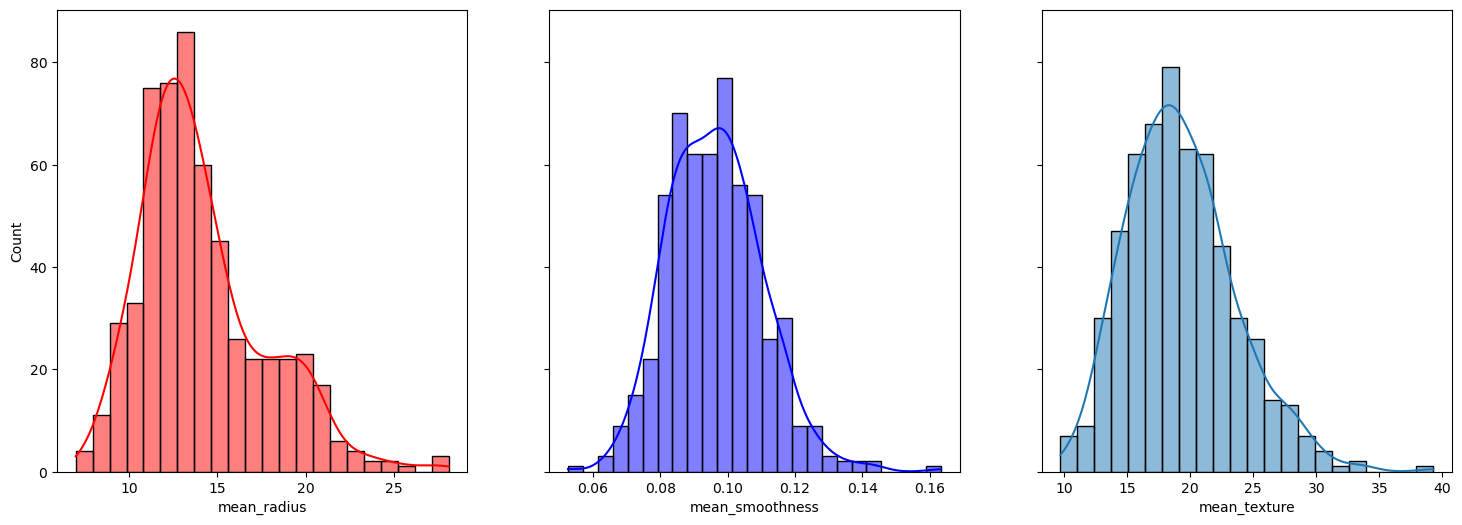

In [13]:
fig, axes = plt.subplots(1,3,figsize=(18,6), sharey=True)
sns.histplot(df,ax=axes[0],x="mean_radius", kde=True, color="r")
sns.histplot(df,ax=axes[1],x="mean_smoothness", kde=True, color="b")
sns.histplot(df,ax=axes[2],x="mean_texture", kde=True)

# prior probability

p(Y=y) 

### 1. calculating p(X=x|Y=y) using gaussian dist.

In [19]:
def calculate_prior(df, Y):
    classes = sorted(list(df[Y].unique()))
    prior = []
    for i in classes:
        prior.append(len(df[df[Y]==i])/len(df))
    return prior

def calculate_likelihood_gaussian(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y]==label]
    mean, std = df[feat_name].mean(), df[feat_name].std()
    p_x_given_y = (1 / (np.sqrt(2 * np.pi) * std)) *  np.exp(-((feat_val-mean)**2 / (2 * std**2 )))
    return p_x_given_y

def naive_bayes_gaussian(df, X, Y):
    # get feature names
    features = list(df.columns)[:-1]

    # calculate prior
    prior = calculate_prior(df, Y)

    Y_pred = []
    # loop over every data sample
    for x in X:
        # calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_gaussian(df, features[i], x[i], Y, labels[j])

        # calculate posterior probability (numerator only)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred) 

In [20]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=.2, random_state=41)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
Y_pred = naive_bayes_gaussian(train, X=X_test, Y="diagnosis")

from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))

[[36  4]
 [ 0 74]]
0.9736842105263158


In [19]:
# from sklearn.naive_bayes import GaussianNB

In [20]:
# df.columns

Index(['mean_radius', 'mean_texture', 'mean_smoothness', 'diagnosis'], dtype='object')

In [21]:
# model = GaussianNB()
# x = df.drop(['diagnosis'], axis=1)
# y = df['diagnosis']

# x_train,x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=42)

In [22]:
# model.fit(x_train, y_train)

GaussianNB()

In [23]:
# y_predict = model.predict(x_test)

In [25]:
# #from sklearn.metrics import accuracy_score

# print(f"accuracy score = {accuracy_score(y_test,y_predict)}")

accuracy score = 0.951048951048951


In [23]:
data.columns

Index(['mean_radius', 'mean_texture', 'mean_smoothness', 'diagnosis'], dtype='object')

In [24]:
x = df.drop(['diagnosis'], axis = 1)
y = df['diagnosis']

In [ ]:
Gausian_naiveB(df, x, y){
    features = list(x.columns)
    
}

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=42)

y_predi = Gausian_naiveB(x_train, x_test, Y='diagnosis')